### Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
import unicodedata
import nltk
import string
from tqdm import tqdm
from time import time

### Load the dataset

In [3]:
df_train = pd.read_csv('OLIDv1.0/trainingset.tsv', sep = '\t')
df_train.columns = ['id', 'tweet', 'sentiment', 'targeted_or_not', 'target_type']

In [4]:
df_train.head()

,id,tweet,sentiment,targeted_or_not,target_type
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN


**sentiment column:**  
1 indicates offensive tweet, 0 indicates not offensive.

**targeted_or_not column:**   
1 indicates targeted tweet, 0 indicates that the tweet is not targeted.  
This column has a meaningful value only when the tweet is offensive.  
                         
**target_type:**   
If the tweet is offensive and targeted,  
1 indicates that the target is an individual  
2 indicates that the target is a group  
3 indicates some other target  
When the tweet is not offensive or offensive but untargeted, there is no meaningful value.

#### Change the text labels to numeric labels

In [5]:
dict_labels = {"OFF": 1, "NOT": 0,
               "TIN": 1, "UNT": 0,
               "IND": 1, "GRP": 2, "OTH": 3}

In [6]:
def convert_labels(x):
    if x in dict_labels.keys():
        return dict_labels[x]
    else:
        return None

#### Sentiment
* OFF = Offensive  
* NOT = Not offensive

NOT    8840
OFF    4400
Name: sentiment, dtype: int64


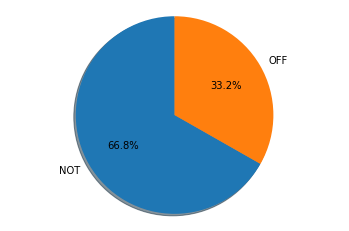

In [7]:
val_counts = df_train['sentiment'].value_counts()
print(val_counts)

labels = val_counts.keys()
sizes = val_counts.values
explode = (0, 0)
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

df_train['sentiment'] = df_train['sentiment'].apply(convert_labels)

#### Targeted or Not Targeted

* TIN = Targeted  
* UNT = Not targeted

TIN    3876
UNT     524
Name: targeted_or_not, dtype: int64


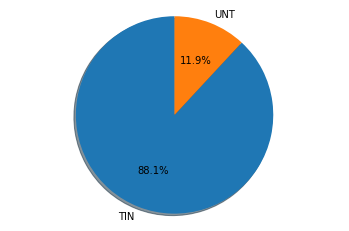

In [8]:
val_counts = df_train['targeted_or_not'].value_counts()
print(val_counts)

labels = val_counts.keys()
sizes = val_counts.values
explode = (0, 0)
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

df_train['targeted_or_not'] = df_train['targeted_or_not'].apply(convert_labels)

#### Target type
* IND = Individual
* GRP = Group
* OTH = Other

IND    2407
GRP    1074
OTH     395
Name: target_type, dtype: int64


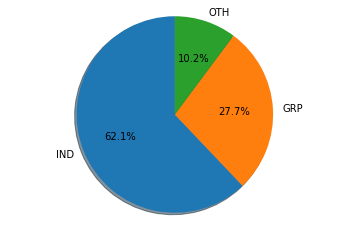

In [9]:
val_counts = df_train['target_type'].value_counts()
print(val_counts)

labels = val_counts.keys()
sizes = val_counts.values
explode = (0, 0, 0)
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

df_train['target_type'] = df_train['target_type'].apply(convert_labels)

## Preprocessing

In [10]:
df_train.head()

,id,tweet,sentiment,targeted_or_not,target_type
0,86426,@USER She should ask a few native Americans wh...,1,0.0,NaN
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,1,1.0,1.0
2,16820,Amazon is investigating Chinese employees who ...,0,NaN,NaN
3,62688,"@USER Someone should'veTaken"" this piece of sh...",1,0.0,NaN
4,43605,@USER @USER Obama wanted liberals &amp; illega...,0,NaN,NaN


#### Converting to Lowercase and Removing Punctuation

In [11]:
from nltk.tokenize import word_tokenize, TweetTokenizer

def my_word_tokenize(doc):
    new_doc = ""
    characters_to_remove = string.punctuation.replace("'", "") + "\n"
    new_doc = ''.join([ch if ch not in characters_to_remove else " " for ch in doc])
    return new_doc.split()

def basic_preprocess(doc):
    '''
    Input: doc (A comment, which is string)
    Output: List of words in the preprocessed document
    Basic preprocessing includes:
    a) converting to lowercase
    b) removing newline characters
    c) removing all punctuation
    d) normalizing to NFKC form
    '''
    
    # Normalization and conversiom to lowercase
    doc = unicodedata.normalize('NFKC', doc).lower()

    # A list of all the words in the document after removing punctuation.
    tokens = my_word_tokenize(doc)
    return tokens

def basic_preprocess_1(doc):
    '''
    Input: doc (A comment, which is string)
    Output: List of words in the preprocessed document
    Basic preprocessing includes:
    a) converting to lowercase
    b) removing newline characters
    c) removing all punctuation
    d) normalizing to NFKC form
    '''
    
    # Normalization and conversiom to lowercase
    doc = unicodedata.normalize('NFKC', doc).lower()
    doc = doc.replace('_', ' ')
    
    # A list of all the words in the document after removing punctuation.
    #tokens = word_tokenize(doc)
    tokens = TweetTokenizer().tokenize(doc)
    # Maps all punctuation marks to 'None'
    table = str.maketrans('', '', string.punctuation.replace('@', '').replace("'", ""))
    # Removes the punctuation marks from each word, if present.
    stripped = [w.translate(table) for w in tokens]
    stripped = [w for w in stripped if (w!='' and w.isalnum()) or w=='@user']
    return stripped

#### Lemmatization

In [12]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import  wordnet

def get_wordnet_pos(treebank_tag):
    '''
    This function is used to convert the Part of Speech tags returned by nltk.pos_tag
    function to the wordnet POS tags.
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
        # Instead of returning None, I am returning the noun tag, because, by default
        # the WordNetLemmatizer assumes that the POS tag is noun.
        
def lemmatize(doc_words):
    '''
    Input: doc_words(A comment) It is a list of words
    Output: A list of words in the document,after lemmatization
    '''
    # Creating Part-of-Speech tags for the words
    pos_tags = nltk.pos_tag(doc_words)
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lem_words = [lemmatizer.lemmatize(word, pos = get_wordnet_pos(tag)) for word, tag in pos_tags]
    return lem_words

#### Removing Stopwords

In [13]:
# Removal of stopwords
from nltk.corpus import stopwords
def remove_stopwords(doc_words):
    '''
    Input: doc_words(a comment) It is a list of words
    Output: List of words in that document, after removing stop words.
    '''
    words_to_remove = set(stopwords.words('english'))
    words = [word for word in doc_words if word not in words_to_remove]
    return words

#### Preprocessing

In [14]:
def preprocess(doc):
    '''
    Input: doc (A comment)
    Output: List of words (after preprocessing)
    '''
    preprocessed_doc = basic_preprocess(doc)
    lemmatized_doc = lemmatize(preprocessed_doc)
    final_preprocessed_doc = remove_stopwords(lemmatized_doc)
    return final_preprocessed_doc

def preprocess_1(doc):
    '''
    Input: doc (A comment)
    Output: List of words (after preprocessing)
    '''
    preprocessed_doc = basic_preprocess_1(doc.replace("’", "'"))
    
    lemmatized_doc = lemmatize(preprocessed_doc)
    final_preprocessed_doc = remove_stopwords(lemmatized_doc)
    return final_preprocessed_doc

In [15]:
start = time()
a = df_train.copy()
a['processed_tweets']= a.apply(lambda row : preprocess_1(row['tweet']), axis = 1)
df = a[['id', 'processed_tweets', 'sentiment', 'targeted_or_not', 'target_type']]
end = time()
print("Time taken (in seconds) for preprocessing the training set:")
print(end - start)

Time taken (in seconds) for preprocessing the training set:
21.05745553970337


In [16]:
df.head()

,id,processed_tweets,sentiment,targeted_or_not,target_type
0,86426,"[@user, ask, native, american, take]",1,0.0,NaN
1,90194,"[@user, @user, go, home, drunk, @user, maga, t...",1,1.0,1.0
2,16820,"[amazon, investigate, chinese, employee, sell,...",0,NaN,NaN
3,62688,"[@user, someone, piece, shit, volcano]",1,0.0,NaN
4,43605,"[@user, @user, obama, want, liberal, illegals,...",0,NaN,NaN


The tweet gets converted into a list of words after preprocessing, when we store the new dataframe as a csv file, the list is stored as string. In order to use it properly as a list, the following method will be helpful:

```
from ast import literal_eval
string_list = "[12, 45]"
new_list = literal_eval(string_list)
```
**new_list** can now be used as a normal list.

In [17]:
df['remove'] = df['processed_tweets'].apply(lambda x: ''.join(list(set(x)))=='@user')
# I did not need to use literal_eval here becuase that nice list of strings I created is still normal
# here. Only when I save and reload it becomes that weird string, which needs to be evaluated with
# ast.literal_eval

# Why have I used list(set(x))? -> To remove rows that have only multiple occurrrences of @user and
# nothing else in them.

In [18]:
df['remove'].value_counts()

False    13172
True        68
Name: remove, dtype: int64

In [19]:
df = df[df['remove']==False]# To remove processed tweets that have just '@user' in them
df = df[['id', 'processed_tweets', 'sentiment', 'targeted_or_not', 'target_type']]

In [20]:
print("Shape of the final dataframe = ",df.shape)
print("Column names = ", df.columns)

Shape of the final dataframe =  (13172, 5)
Column names =  Index(['id', 'processed_tweets', 'sentiment', 'targeted_or_not',
       'target_type'],
      dtype='object')


In [21]:
df.reset_index(drop=True, inplace=True)
df.to_csv('processed_trainingset.csv')

In [22]:
dftesta = pd.read_csv('OLIDv1.0/testset-levela.tsv', sep = '\t')
dftesta.head()

,id,tweet
0,15923,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...
1,27014,"#ConstitutionDay is revered by Conservatives, ..."
2,30530,#FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...
3,13876,#Watching #Boomer getting the news that she is...
4,60133,#NoPasaran: Unity demo to oppose the far-right...


In [23]:
dflaba = pd.read_csv('OLIDv1.0/labels-levela.csv', header=None)
dflabb = pd.read_csv('OLIDv1.0/labels-levelb.csv', header=None)
dflabc = pd.read_csv('OLIDv1.0/labels-levelc.csv', header=None)
dflaba.columns = ['id', 'sentiment']
dflabb.columns = ['id', 'targeted_or_not']
dflabc.columns = ['id', 'target_type']
dflaba.head()

,id,sentiment
0,15923,OFF
1,27014,NOT
2,30530,NOT
3,13876,NOT
4,60133,OFF


In [24]:
df_test = pd.merge(dftesta, dflaba, how='left', on=['id'])
df_test.head()

,id,tweet,sentiment
0,15923,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...,OFF
1,27014,"#ConstitutionDay is revered by Conservatives, ...",NOT
2,30530,#FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...,NOT
3,13876,#Watching #Boomer getting the news that she is...,NOT
4,60133,#NoPasaran: Unity demo to oppose the far-right...,OFF


In [25]:
df_test = pd.merge(df_test, dflabb, how='left', on=['id'])
df_test.head()

,id,tweet,sentiment,targeted_or_not
0,15923,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...,OFF,TIN
1,27014,"#ConstitutionDay is revered by Conservatives, ...",NOT,NaN
2,30530,#FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...,NOT,NaN
3,13876,#Watching #Boomer getting the news that she is...,NOT,NaN
4,60133,#NoPasaran: Unity demo to oppose the far-right...,OFF,TIN


In [26]:
df_test = pd.merge(df_test, dflabc, how='left', on=['id'])
df_test.head()

,id,tweet,sentiment,targeted_or_not,target_type
0,15923,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...,OFF,TIN,OTH
1,27014,"#ConstitutionDay is revered by Conservatives, ...",NOT,NaN,NaN
2,30530,#FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...,NOT,NaN,NaN
3,13876,#Watching #Boomer getting the news that she is...,NOT,NaN,NaN
4,60133,#NoPasaran: Unity demo to oppose the far-right...,OFF,TIN,GRP


In [27]:
start = time()
b = df_test.copy()
b['processed_tweets']= b.apply(lambda row : preprocess_1(row['tweet']), axis = 1)
df_test_save = b[['id', 'processed_tweets', 'sentiment', 'targeted_or_not', 'target_type']]
end = time()
print("Time taken (in seconds) for preprocessing the test set:")
print(end - start)

Time taken (in seconds) for preprocessing the test set:
1.2404768466949463


In [28]:
df_test_save['sentiment'] = df_test_save['sentiment'].apply(convert_labels)
df_test_save['targeted_or_not'] = df_test_save['targeted_or_not'].apply(convert_labels)
df_test_save['target_type'] = df_test_save['target_type'].apply(convert_labels)

df_test_save.reset_index(drop=True, inplace=True)
df_test_save.to_csv('processed_testset.csv')